# Figure 2: Host DNA percentage

## A: Human host DNA percentage

Importing libraries

In [3]:
import multiprocessing
import pandas as pd
import subprocess
import pysam
import os
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import ptitprince as pt
from plotnine import *

### Summary of BAM files generate by [Anonymap](https://github.com/maxibor/anonymap)

|     Lab    |    Contact    | Origin of samples | Number of samples | Reference human genome used | Westernized ?|
|:----------:|:-------------:|:-----------------:|:-----------------:|:---------------------------:|:-------------|
| Kostic Lab | Marsha Wibowo |         ?         |         49        |            GRCh38           |      yes     |
|  Lewis Lab |  Tanvi Honap  |    Burkina Faso   |         69        |             hg19            |       no     | 
|PRJEB35961 BGISEQ |     -     |    China          |         39        |             GRCh38          |     yes    |

Setting up the list of bam files

In [4]:
human_non_western_bam_dir = "../../data/lewis_lab"
human_non_western_bams = [i for i in os.listdir(human_non_western_bam_dir) if i.endswith(".bam")]
human_western_bam_dir = "../../data/kostic_lab" 
human_western_bams = [i for i in os.listdir(human_western_bam_dir) if i.endswith(".bam")]

Defining functions to parse alignment files

In [10]:
def bam_index(bam, bamdir):
    #print(bam)
    cmd = f"samtools index {bamdir}/{bam}"
    try:
        #print(cmd)
        subprocess.check_output(cmd, shell=True)
    except subprocess.CalledProcessError:
        #print(f"Error indexing {bam}")
        pass

In [11]:
def perChromosome(chr, bam, min_id, min_len):
    mapped = 0
    bamfile = pysam.AlignmentFile(bam, "rb")
    reads = bamfile.fetch(chr, multiple_iterators=True)
    for read in reads:
        try:
            cigar = read.get_cigar_stats()[0]
            cigar_d = {'M':cigar[0], 'I': cigar[1], 'D': cigar[2], 'NM': cigar[-1]}
            aln_cols = cigar_d['M']+cigar_d['I']+cigar_d['D']
            nm = cigar_d['NM']
            if cigar_d['M'] == 0:
                continue
            else:
                identity = (aln_cols-nm)/(aln_cols)
                if identity >= min_id and aln_cols > min_len :
                    mapped +=1
        except:
            continue
    return(mapped)

def getNumberMappedReadsMultiprocess(bam, processes, min_id, min_len):
    try:
        bamfile = pysam.AlignmentFile(bam, "rb")
    except ValueError as e:
        print(e)
    chrs = bamfile.references

    perChromosomePartial = partial(
        perChromosome, bam=bam, min_id = min_id, min_len = min_len)
    p = multiprocessing.Pool(processes)
    result = p.imap_unordered(perChromosomePartial, chrs)
    p.close()
    p.join()
    mapped = sum(result)
    total = bamfile.mapped + bamfile.unmapped
    #print(f"filtered: {mapped}, mapped: {bamfile.mapped}, unmapped: {bamfile.unmapped}, total: {bamfile.mapped + bamfile.unmapped}")
    return({bam.split("/")[-1].split(".")[0]:[mapped, total]})   

#### Handling westernized bam files 

In [ ]:
index_western = partial(bam_index, bamdir = human_western_bam_dir)
with multiprocessing.Pool(10) as p:
    p.map(index_western, human_western_bams)

In [ ]:
western_res = {}
for i in tqdm(human_western_bams):
    print(f"{human_western_bam_dir}/{i}")
    western_res.update(getNumberMappedReadsMultiprocess(bam = f"{human_western_bam_dir}/{i}", processes=10, min_id = 0.95, min_len=20))

In [11]:
western_human = pd.DataFrame(western_res).T
western_human.columns = 'human_count','all_count'
western_human["percentage_endo"] = western_human['human_count']/western_human['all_count']*100

In [12]:
western_human.head()

,human_count,all_count,percentage_endo
E5,175600,11487470,1.528622
F4,183259,9696234,1.890002
E2,214203,8327324,2.572291
E1,227278,10907632,2.083660
B10,375059,11695702,3.206811


In [13]:
western_human['percentage_endo'].describe()

count    49.000000
mean      1.808109
std       0.806107
min       0.409995
25%       1.258292
50%       1.667870
75%       2.228570
max       3.731088
Name: percentage_endo, dtype: float64

In [ ]:
western_human.to_csv("results/western_human.csv")

In [8]:
western_human = pd.read_csv("results/western_human.csv", index_col=0)

In [9]:
western_human.head()

,human_count,all_count,percentage_endo
E5,175600,11487470,1.528622
F4,183259,9696234,1.890002
E2,214203,8327324,2.572291
E1,227278,10907632,2.083660
B10,375059,11695702,3.206811


In [10]:
western_human['organism'] = western_human.shape[0]*['Westernized human']

## Chinese PRJEB35961 BGISEQ samples

In [141]:
cn_dir = "../../data/PRJEB35961_bgiseq"
cn_bams = [i for i in os.listdir(cn_dir) if i.endswith("aligned.bam")]

In [ ]:
index_chinese = partial(bam_index, bamdir = cn_dir)
with multiprocessing.Pool(10) as p:
    p.map(index_chinese, cn_bam)

In [143]:
cn_mapped = {}
for i in tqdm(cn_bams):
    try:
        cn_mapped.update(getNumberMappedReadsMultiprocess(f"{cn_dir}/{i}", processes=10, min_id=0.95, min_len=20))
    except:
        continue

100%|██████████| 40/40 [00:58<00:00,  1.52s/it]


In [144]:
cn_human = pd.DataFrame(cn_mapped).T
cn_human.columns = ['human_count','all_count']
cn_human["percentage_endo"] = cn_human['human_count']/cn_human['all_count']*100

In [145]:
cn_human.to_csv("results/chinese_PRJEB35961.csv")

In [5]:
cn_human = pd.read_csv("results/chinese_PRJEB35961.csv", index_col=0)

In [6]:
cn_human['organism'] =  cn_human.shape[0] * ['Westernized human']

In [7]:
cn_human['percentage_endo'].describe()

count    39.000000
mean      0.020529
std       0.037909
min       0.000037
25%       0.000274
50%       0.001878
75%       0.023942
max       0.178762
Name: percentage_endo, dtype: float64

#### Handling non westernized bam files 

Because these files were anonymized for the mapping position as well, we can not index them and have to parse them manually from sam files

In [ ]:
def bam2sam(bamfile, bamdir):
    print(bamfile)
    basename = bamfile.split(".")[0]
    cmd = f"samtools view {bamdir}/{bamfile} > {bamdir}/{basename}.sam"
    print(cmd)
    subprocess.check_output(cmd, shell = True)

In [ ]:
non_western_bam2sam = partial(bam2sam, bamdir = human_non_western_bam_dir)
with multiprocessing.Pool(10) as p:
    p.map(western_bam2sam, human_non_western_bams)

In [17]:
regex = re.compile("(\d*)[MID]")
def samline(sam, regex=regex, min_id = 0.95, min_len=20):
    cnt = 0
    all_cnt = 0
    print(sam)
    with open(sam, 'r') as f:
        for l in f:
            lsplit = l.split()
            cigar = lsplit[5]
            all_cnt +=1
            if len(cigar) > 1:
                nm = int(lsplit[16].split(':')[-1])
                al_len = sum([int(i) for i in re.findall(regex, cigar)])
                ident = (al_len - nm)/al_len
                if ident >= min_id and al_len>min_len:
                    cnt+=1
            else:
                continue
    return({sam:[cnt,all_cnt]})

In [18]:
human_non_western_sams = [i for i in os.listdir(human_non_western_bam_dir) if i.endswith(".sam")]

In [20]:
with multiprocessing.Pool(10) as p:
    res = list(tqdm(p.map(samline, [f"{human_non_western_bam_dir}/{s}" for s in human_non_western_sams]), total=len(human_non_western_sams)))

../../data/lewis_lab/bftm030236.sam
../../data/lewis_lab/bftm0401ecol39.sam
../../data/lewis_lab/bftm140428.sam
../../data/lewis_lab/bftm140127.sam
../../data/lewis_lab/bftm070332.sam
../../data/lewis_lab/bftm130122.sam
../../data/lewis_lab/bftm2301ext33.sam
../../data/lewis_lab/bftm220210.sam
../../data/lewis_lab/bftm180134.sam
../../data/lewis_lab/bftm1003ext22.sam
../../data/lewis_lab/bftm280135.sam
../../data/lewis_lab/bftm140341.sam
../../data/lewis_lab/bftm2401ext31.sam
../../data/lewis_lab/bftm1502ecol15.sam
../../data/lewis_lab/bftm100113.sam
../../data/lewis_lab/bftm230440.sam
../../data/lewis_lab/bftm190220.sam
../../data/lewis_lab/bftm2103ext32.sam
../../data/lewis_lab/bftm0202ext20.sam
../../data/lewis_lab/bftm0803ext30.sam
../../data/lewis_lab/bftm30016.sam
../../data/lewis_lab/bftm1002ecol4.sam
../../data/lewis_lab/bftm110237.sam
../../data/lewis_lab/bftm2204ext27.sam
../../data/lewis_lab/bftm1104ecol11.sam
../../data/lewis_lab/bftm270223.sam
../../data/lewis_lab/bftm0402



  0%|          | 0/69 [00:00<?, ?it/s]

100%|██████████| 69/69 [00:00<00:00, 42868.76it/s]

In [21]:
result_non_western = {}
for d in res:
    result_non_western.update(d)

In [22]:
non_western_human = pd.DataFrame(result_non_western).T
non_western_human = non_western_human.set_index(pd.Series(non_western_human.index.str.split("/lewis_lab/", expand=True).to_frame().iloc[:,1], name="sample"))
non_western_human.columns = ['human_count','all_count']
non_western_human['percentage_endo'] = non_western_human['human_count']/non_western_human['all_count']*100

In [23]:
non_western_human.head()

,human_count,all_count,percentage_endo
sample,,,
bftm030236.sam,79010,27571762,0.286561
bftm1502ecol15.sam,39878,51388140,0.077602
bftm130122.sam,13086,41265242,0.031712
bftm100113.sam,1330862,100223950,1.327888
bftm0401ecol39.sam,35016,42149188,0.083076


In [24]:
non_western_human['percentage_endo'].describe()

count    69.000000
mean      0.869732
std       2.394456
min       0.012917
25%       0.039799
50%       0.090369
75%       0.300655
max      13.101175
Name: percentage_endo, dtype: float64

In [26]:
non_western_human.to_csv("results/non_western_human.csv")

In [11]:
non_western_human = pd.read_csv("results/non_western_human.csv", index_col=0)

In [12]:
non_western_human['organism'] = non_western_human.shape[0]*['Non westernized Human']

In [13]:
non_western_human = non_western_human[non_western_human['percentage_endo'] < 5] 

In [14]:
non_western_human['percentage_endo'].describe()

count    66.000000
mean      0.410199
std       0.977017
min       0.012917
25%       0.039307
50%       0.084137
75%       0.289112
max       4.837813
Name: percentage_endo, dtype: float64

## B: Dog host DNA percentage

In [13]:
dog_dir = "../../data/dog_PRJEB20308"

In [14]:
dog_bams= [i for i in os.listdir(dog_dir) if i.endswith(".unfiltered.aligned.bam")]

In [15]:
index_dog = partial(bam_index, bamdir = dog_dir)
with multiprocessing.Pool(10) as p:
    list(tqdm(p.imap(index_dog, dog_bams), total = len(dog_bams)))

100%|██████████| 150/150 [00:50<00:00,  2.46it/s]


In [16]:
dog_mapped = {}
for i in tqdm(dog_bams):
    try:
        dog_mapped.update(getNumberMappedReadsMultiprocess(f"{dog_dir}/{i}", processes=10, min_id=0.95, min_len=20))
    except:
        continue

100%|██████████| 150/150 [00:35<00:00,  5.42it/s]


In [17]:
dog_count = pd.DataFrame(dog_mapped).T

In [18]:
dog_count.columns = ['human_count','all_count']

In [19]:
dog_count['percentage_endo'] = dog_count['human_count']/dog_count['all_count']*100

In [20]:
dog_count['organism'] = ['Dog']*dog_count.shape[0]

In [ ]:
dog_count.to_csv("results/dogs.csv")

In [16]:
dog_count = pd.read_csv('results/dogs.csv')

# C: Combining results

In [17]:
endo = western_human.append(non_western_human).append(dog_count)

In [18]:
endo['organism'].value_counts()

Dog                      150
Non westernized Human     66
Westernized human         49
Name: organism, dtype: int64

## Color palette:
- Westernized human: '#b2182b'
- Non Westernized human: '#ef8a62'
- '#fddbc7'
- '#d1e5f0'
- '#67a9cf'
- Dog: '#2166ac'

/projects1/users/borry/15_miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/projects1/users/borry/15_miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: results/figure2.png
  warn('Filename: {}'.format(filename))


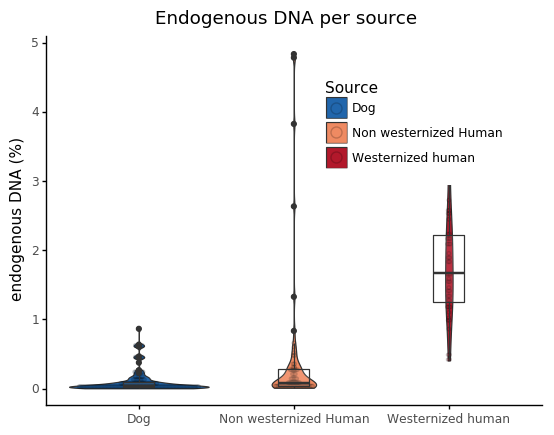

In [45]:
p = ggplot(endo, aes(x="organism", y="percentage_endo")) + geom_violin(aes(fill="organism"))
p = p + geom_boxplot(alpha=0.1, width=0.2) + geom_dotplot(aes(fill='organism'),binaxis='y', stackdir='center', binwidth=0.05, alpha=0.2, stackratio = 0.4)
p = p + labs(title = 'Endogenous DNA per source', subtitle = "A subtitle",x = '', y='endogenous DNA (%)') 
p = p + theme_classic() + theme(legend_position = (0.7,0.7))
p = p + scale_fill_manual(name = "Source", values = {"Dog":"#2166ac","Non westernized Human":"#ef8a62","Westernized human":"#b2182b"})
p.draw()
p.save('results/figure2.png', dpi=300)

### Testing for group median inequality
"The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal."

In [31]:
dog_endo = endo.loc[endo.index[endo['organism'] == 'Dog'],'percentage_endo']
w_human_endo = endo.loc[endo.index[endo['organism'] == 'Westernized human'],'percentage_endo']
nw_human_endo = endo.loc[endo.index[endo['organism'] == 'Non westernized Human'],'percentage_endo']                      

In [32]:
stats.kruskal(dog_endo, w_human_endo, nw_human_endo).pvalue

1.037823801043944e-26

The *p value* is < 0.05, there is a difference between the medians of the three sources

"The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean."

In [33]:
stats.f_oneway(dog_endo, w_human_endo, nw_human_endo).pvalue

3.4193515302052062e-43

The p value is < 0.05, there is a difference between the means of the three sources

#### Dog vs Non westernized human

"This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values."

In [34]:
stats.ttest_ind(dog_endo, nw_human_endo, equal_var=False)

Ttest_indResult(statistic=-2.511641976848075, pvalue=0.014451907070305855)

Non identical in means (H0 rejected)

#### Dog vs Human

In [35]:
human_endo= endo.loc[endo.index[endo['organism'].isin(['Westernized human','Non westernized Human'])] ,'percentage_endo']

In [36]:
human_endo.describe()

count    115.000000
mean       1.005830
std        1.140143
min        0.012917
25%        0.069201
50%        0.457735
75%        1.660680
max        4.837813
Name: percentage_endo, dtype: float64

In [37]:
dog_endo.describe()

count    150.000000
mean       0.106391
std        0.158886
min        0.005393
25%        0.018799
50%        0.041548
75%        0.100043
max        0.865627
Name: percentage_endo, dtype: float64

In [38]:
stats.ttest_ind(dog_endo, human_endo, equal_var=False)

Ttest_indResult(statistic=-8.397549567642862, pvalue=1.2039614141507107e-13)

Non identical in means (H0 rejected)